In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.io import loadmat
from sklearn.preprocessing import Normalizer
from tensorflow.keras import layers, losses, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [2]:
# Read data
data = loadmat("../data/breastw.mat")

X = data['X']
y = data['y']
X = pd.DataFrame(X)
y = pd.DataFrame(y)

In [3]:
# Normalize data
scaler = Normalizer()
X_scaled = pd.DataFrame(scaler.fit_transform(X))

df = pd.concat([X_scaled, y], ignore_index=True, axis=1)
df.columns = [f'X{i}' for i in range(1, X.shape[1] + 1)] + ['isOutlier']

In [4]:
# Split normal data and outliers
df_normal = df[df.isOutlier == 0]
df_normal.columns = [f'X{i}' for i in range(1, X.shape[1] + 1)] + ['isOutlier']

df_outlier = df[df.isOutlier == 1]
df_outlier.columns = [f'X{i}' for i in range(1, X.shape[1] + 1)] + ['isOutlier']

df_normal.drop(["isOutlier"], axis=1, inplace=True)
df_outlier.drop(['isOutlier'], axis=1, inplace=True)

/Users/muratkoptur/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [5]:
# Split normal data as train and validation
train_size = int(len(df_normal) * 0.67)
valid_size = len(df_normal) - train_size

train_normal = df_normal.iloc[[i for i in range(train_size)], :]
valid_normal = df_normal.iloc[[i for i in range(train_size, len(df_normal))], :]

In [6]:
# Sampling class
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [7]:
# Autoencoder model
latent_dim = 2

encoder_inputs = Input(shape=(9,))
x = layers.Dense(9, activation='elu')(encoder_inputs)
x = layers.Dense(6, activation='elu')(x)
x = layers.Dense(3, activation='elu')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = Input(shape=(latent_dim,))
x = layers.Dense(3, activation="elu")(latent_inputs)
x = layers.Dense(6, activation="elu")(x)
x = layers.Dense(9, activation="elu")(x)
decoder_outputs = x
decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 9 * 9
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 9)            90          input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 6)            60          dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 3)            21          dense_1[0][0]                    
____________________________________________________________________________________________

In [11]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=Adam(), 
            metrics=['mean_absolute_error'], 
            loss=losses.mean_absolute_error)
history = vae.fit(train_normal, 
        epochs=200, 
        batch_size=128,
        validation_data=(valid_normal,valid_normal)
       ).history

Epoch 1/200
1/3 [=========>....................] - ETA: 0s - loss: 113.7358 - reconstruction_loss: 113.5888 - kl_loss: 0.1469WARNING:tensorflow:Layer vae_1 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

3/3 [==============================] - 0s 70ms/step - loss: 117.3761 - reconstruction_loss: 117.2119 - kl_loss: 0.1642 - val_loss: 0.1572 - val_mean_absolute_error: 0

3/3 [==============================] - 0s 13ms/step - loss: 77.5361 - reconstruction_loss: 77.3926 - kl_loss: 0.1435 - val_loss: 0.1200 - val_mean_absolute_error: 0.1200
Epoch 42/200
3/3 [==============================] - 0s 13ms/step - loss: 72.1462 - reconstruction_loss: 71.9982 - kl_loss: 0.1479 - val_loss: 0.1198 - val_mean_absolute_error: 0.1198
Epoch 43/200
3/3 [==============================] - 0s 13ms/step - loss: 76.6029 - reconstruction_loss: 76.4594 - kl_loss: 0.1436 - val_loss: 0.1196 - val_mean_absolute_error: 0.1196
Epoch 44/200
3/3 [==============================] - 0s 13ms/step - loss: 65.6903 - reconstruction_loss: 65.5417 - kl_loss: 0.1486 - val_loss: 0.1193 - val_mean_absolute_error: 0.1193
Epoch 45/200
3/3 [==============================] - 0s 13ms/step - loss: 74.0192 - reconstruction_loss: 73.8639 - kl_loss: 0.1553 - val_loss: 0.1190 - val_mean_absolute_error: 0.1190
Epoch 46/200
3/3 [==============================] - 0s 13ms/step - loss: 71.8049 - reconstruction_

Epoch 86/200
3/3 [==============================] - 0s 13ms/step - loss: 53.5111 - reconstruction_loss: 53.3437 - kl_loss: 0.1674 - val_loss: 0.1120 - val_mean_absolute_error: 0.1120
Epoch 87/200
3/3 [==============================] - 0s 15ms/step - loss: 51.1657 - reconstruction_loss: 51.0035 - kl_loss: 0.1622 - val_loss: 0.1118 - val_mean_absolute_error: 0.1118
Epoch 88/200
3/3 [==============================] - 0s 12ms/step - loss: 53.0149 - reconstruction_loss: 52.8493 - kl_loss: 0.1656 - val_loss: 0.1116 - val_mean_absolute_error: 0.1116
Epoch 89/200
3/3 [==============================] - 0s 13ms/step - loss: 53.1312 - reconstruction_loss: 52.9711 - kl_loss: 0.1601 - val_loss: 0.1114 - val_mean_absolute_error: 0.1114
Epoch 90/200
3/3 [==============================] - 0s 12ms/step - loss: 52.3406 - reconstruction_loss: 52.1773 - kl_loss: 0.1633 - val_loss: 0.1112 - val_mean_absolute_error: 0.1112
Epoch 91/200
3/3 [==============================] - 0s 13ms/step - loss: 51.5016 - re

3/3 [==============================] - 0s 13ms/step - loss: 50.7778 - reconstruction_loss: 50.5999 - kl_loss: 0.1778 - val_loss: 0.1022 - val_mean_absolute_error: 0.1022
Epoch 131/200
3/3 [==============================] - 0s 13ms/step - loss: 49.2926 - reconstruction_loss: 49.1176 - kl_loss: 0.1750 - val_loss: 0.1020 - val_mean_absolute_error: 0.1020
Epoch 132/200
3/3 [==============================] - 0s 13ms/step - loss: 49.7650 - reconstruction_loss: 49.5931 - kl_loss: 0.1719 - val_loss: 0.1018 - val_mean_absolute_error: 0.1018
Epoch 133/200
3/3 [==============================] - 0s 13ms/step - loss: 49.6812 - reconstruction_loss: 49.4982 - kl_loss: 0.1829 - val_loss: 0.1015 - val_mean_absolute_error: 0.1015
Epoch 134/200
3/3 [==============================] - 0s 13ms/step - loss: 49.4996 - reconstruction_loss: 49.3190 - kl_loss: 0.1805 - val_loss: 0.1013 - val_mean_absolute_error: 0.1013
Epoch 135/200
3/3 [==============================] - 0s 15ms/step - loss: 49.2097 - reconstruc

3/3 [==============================] - 0s 12ms/step - loss: 49.0867 - reconstruction_loss: 48.9099 - kl_loss: 0.1769 - val_loss: 0.0956 - val_mean_absolute_error: 0.0956
Epoch 175/200
3/3 [==============================] - 0s 13ms/step - loss: 48.5570 - reconstruction_loss: 48.3879 - kl_loss: 0.1690 - val_loss: 0.0955 - val_mean_absolute_error: 0.0955
Epoch 176/200
3/3 [==============================] - 0s 12ms/step - loss: 49.0694 - reconstruction_loss: 48.8928 - kl_loss: 0.1766 - val_loss: 0.0955 - val_mean_absolute_error: 0.0955
Epoch 177/200
3/3 [==============================] - 0s 13ms/step - loss: 48.8643 - reconstruction_loss: 48.6811 - kl_loss: 0.1832 - val_loss: 0.0955 - val_mean_absolute_error: 0.0955
Epoch 178/200
3/3 [==============================] - 0s 13ms/step - loss: 48.6229 - reconstruction_loss: 48.4362 - kl_loss: 0.1867 - val_loss: 0.0955 - val_mean_absolute_error: 0.0955
Epoch 179/200
3/3 [==============================] - 0s 12ms/step - loss: 48.4280 - reconstruc

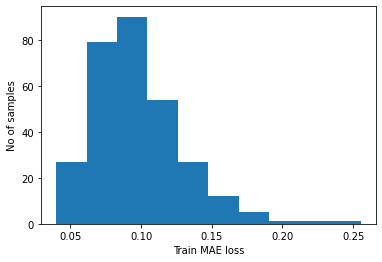

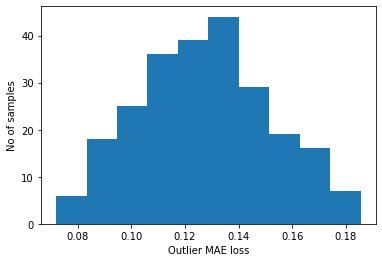

In [12]:
# Calculate reconstruction errors for normal and outliers
train_normal_pred = vae.predict(train_normal)
train_mae_loss = np.mean(np.abs(train_normal_pred - train_normal), axis=1)
outlier_pred = vae.predict(df_outlier)
outlier_mae_loss = np.mean(np.abs(outlier_pred - df_outlier), axis=1)

plt.hist(train_mae_loss)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

plt.hist(outlier_mae_loss)
plt.xlabel("Outlier MAE loss")
plt.ylabel("No of samples")
plt.show()

In [13]:
# Calculate MAE threshold for anomalies
# I'll choose threshold as median loss
threshold = np.mean(train_mae_loss)
print("Reconstruction error threshold: ", threshold)
false_alarms = train_mae_loss > threshold
anomalies = outlier_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

# F1 score for classification
f1_score = np.sum(anomalies) / (np.sum(anomalies) + 1 / 2 * (np.sum(false_alarms) + anomalies.size - np.sum(anomalies)))
print(f1_score)

Reconstruction error threshold:  0.0966608433227932
Number of anomaly samples:  213
Indices of anomaly samples:  (array([  0,   3,   4,   5,   7,   9,  10,  11,  12,  13,  14,  15,  16,
        17,  18,  19,  20,  21,  23,  24,  25,  26,  27,  28,  29,  30,
        31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  51,  52,  53,  54,  55,  56,  57,
        59,  60,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
        73,  74,  75,  76,  77,  78,  80,  81,  82,  84,  85,  86,  87,
        88,  89,  90,  91,  92,  93,  94,  97,  98,  99, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 144, 145,
       146, 148, 149, 150, 151, 152, 153, 155, 156, 157, 159, 160, 161,
       162, 163, 164, 165, 167, 168, 169, 171, 172, 173, 174, 175, 176,
       177, 178, 179, 